In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

image_dir = "UTKFace/UTKFace"  # This is the correct path

data = []
age_labels = []
gender_labels = []

for filename in os.listdir(image_dir):
    try:
        if not filename.endswith(".jpg"):
            continue

        age, gender, *_ = filename.split("_")
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (64, 64))

        data.append(img)
        age_labels.append(int(age))
        gender_labels.append(int(gender))
    except Exception as e:
        print(f"Skipping {filename}: {e}")
        continue

print(f"✅ Total valid images loaded: {len(data)}")

X = np.array(data) / 255.0
y_age = np.array(age_labels)
y_gender = np.array(gender_labels)

# Split into train/test
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42
)

print("✅ Data preprocessed and ready for model training.")


✅ Total valid images loaded: 23708
✅ Data preprocessed and ready for model training.


In [3]:
pip install keras-tuner --quiet


Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import keras_tuner as kt

def build_model(hp):
    input_layer = Input(shape=(64, 64, 3))

    # Conv layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    # Tune number of units in dense layers
    units1 = hp.Int('units1', min_value=128, max_value=512, step=64)
    x = Dense(units1, activation='relu')(x)
    x = BatchNormalization()(x)
    dropout1 = hp.Float('dropout1', 0.3, 0.7, step=0.1)
    x = Dropout(dropout1)(x)

    units2 = hp.Int('units2', min_value=64, max_value=256, step=64)
    x = Dense(units2, activation='relu')(x)
    x = BatchNormalization()(x)
    dropout2 = hp.Float('dropout2', 0.2, 0.5, step=0.1)
    x = Dropout(dropout2)(x)

    # Outputs
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
    age_output = Dense(1, activation='linear', name='age_output')(x)

    model = Model(inputs=input_layer, outputs=[gender_output, age_output])

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss={
            'gender_output': 'binary_crossentropy',
            'age_output': 'mae'
        },
        metrics={
            'gender_output': 'accuracy',
            'age_output': 'mae'
        }
    )

    return model

# Create tuner
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_gender_output_accuracy", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='age_gender_tuning'
)

# Example: Replace these with your actual data loaders
# train_dataset = ...
# val_dataset = ...

# Run hyperparameter search - replace epochs and batch_size as per your setup
# tuner.search(train_dataset, validation_data=val_dataset, epochs=10)

# After tuning, get the best model and hyperparameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
# print(best_hp.values)


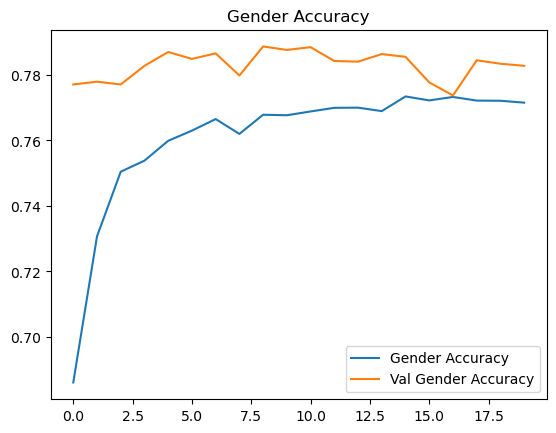

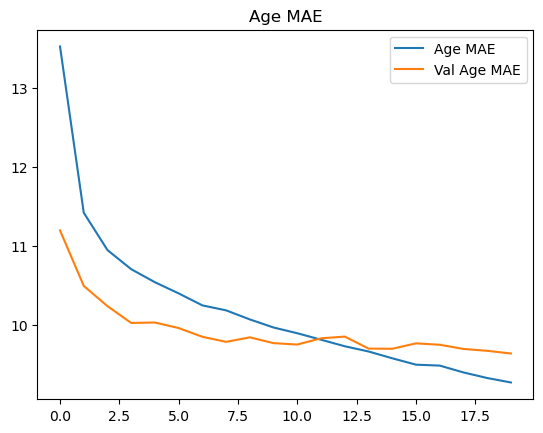

In [5]:
# import matplotlib.pyplot as plt

# # Gender accuracy
# plt.plot(history.history['gender_output_accuracy'], label='Gender Accuracy')
# plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Accuracy')
# plt.legend()
# plt.title("Gender Accuracy")
# plt.show()

# # Age MAE
# plt.plot(history.history['age_output_mae'], label='Age MAE')
# plt.plot(history.history['val_age_output_mae'], label='Val Age MAE')
# plt.legend()
# plt.title("Age MAE")
# plt.show()


In [8]:
import tensorflow as tf

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train,
    {
        "gender_output": y_gender_train,
        "age_output": y_age_train
    }
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    X_test,
    {
        "gender_output": y_gender_test,
        "age_output": y_age_test
    }
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Now run the hyperparameter tuning search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Trial 10 Complete [00h 09m 18s]
val_gender_output_accuracy: 0.8920286893844604

Best val_gender_output_accuracy So Far: 0.8920286893844604
Total elapsed time: 01h 40m 30s


In [9]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("✅ Best Hyperparameters:")
print(best_hp.values)


✅ Best Hyperparameters:
{'units1': 128, 'dropout1': 0.3, 'units2': 128, 'dropout2': 0.2, 'learning_rate': 0.00021477648367203856}


C:\Users\saroj\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 99ms/step - age_output_loss: 6.1888 - age_output_mae: 6.1888 - gender_output_accuracy: 0.8805 - gender_output_loss: 0.2758 - loss: 6.4646 - val_age_output_loss: 6.4665 - val_age_output_mae: 6.4772 - val_gender_output_accuracy: 0.8726 - val_gender_output_loss: 0.2771 - val_loss: 6.7550
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - age_output_loss: 6.0474 - age_output_mae: 6.0474 - gender_output_accuracy: 0.8813 - gender_output_loss: 0.2691 - loss: 6.3166 - val_age_output_loss: 6.2397 - val_age_output_mae: 6.2541 - val_gender_output_accuracy: 0.8699 - val_gender_output_loss: 0.2839 - val_loss: 6.5392
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - age_output_loss: 5.9431 - age_output_mae: 5.9431 - gender_output_accuracy: 0.8878 - gender_output_loss: 0.2620 - loss: 6.2051 - val_age_output_loss: 6.7522 - val_age_output_mae: 6.7688 - val_gender_output_accuracy: 0.8922 - val_gender_output_loss: 0.2429 - val_loss: 7.0122
Epoch 4/10

In [11]:
best_model.save("best_age_gender_model.keras")

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - age_output_loss: 6.4477 - age_output_mae: 6.4477 - gender_output_accuracy: 0.8971 - gender_output_loss: 0.2424 - loss: 6.6902

✅ Evaluation Results:
loss: 6.7240
compile_metrics: 0.2260
gender_output_loss: 6.4958
age_output_loss: 6.4973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


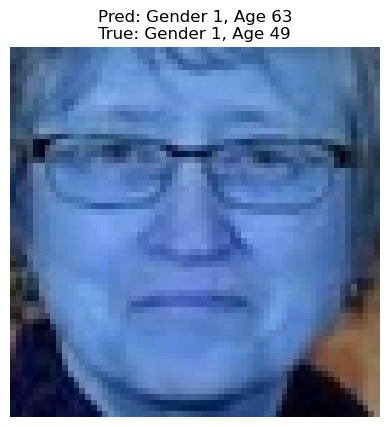

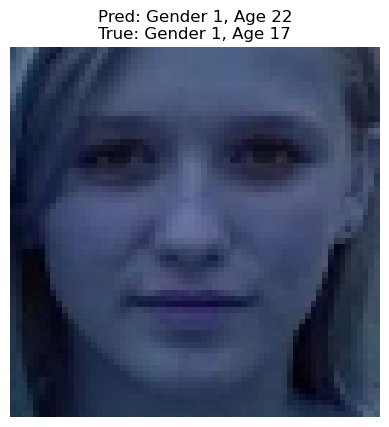

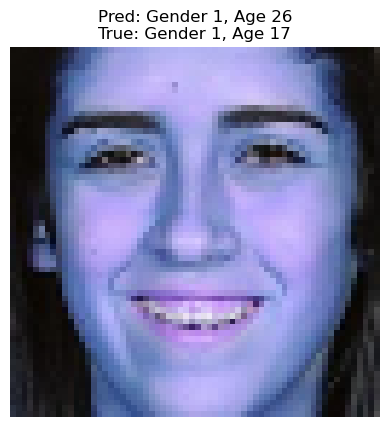

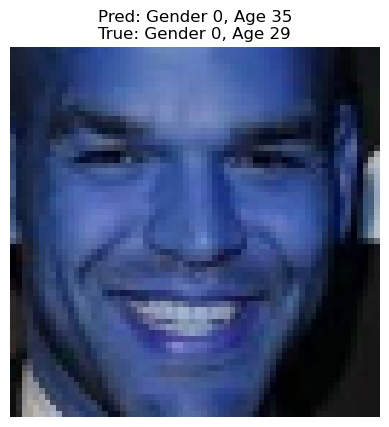

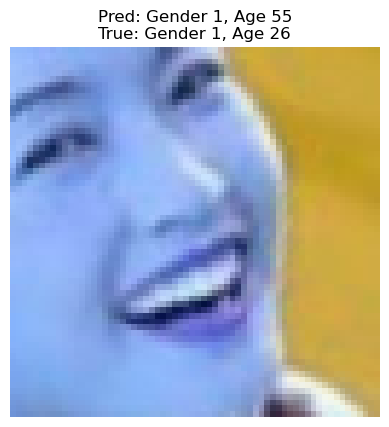

In [12]:
# Load the trained model (if not already loaded)
from tensorflow.keras.models import load_model

model = load_model("best_age_gender_model.keras")

# Evaluate on the test/validation set
eval_results = model.evaluate(val_dataset)
print("\n✅ Evaluation Results:")
for name, value in zip(model.metrics_names, eval_results):
    print(f"{name}: {value:.4f}")

# Optional: Predict on a few samples and view output
import numpy as np
import matplotlib.pyplot as plt

# Take one batch from validation set
for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    gender_preds = (predictions[0] > 0.5).astype(int)
    age_preds = predictions[1].astype(int)

    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title(f"Pred: Gender {gender_preds[i][0]}, Age {age_preds[i][0]}\nTrue: Gender {labels['gender_output'][i].numpy()}, Age {labels['age_output'][i].numpy()}")
        plt.axis('off')
        plt.show()

In [13]:
eval_results = model.evaluate(val_dataset)

for name, value in zip(model.metrics_names, eval_results):
    print(f"{name}: {value:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - age_output_loss: 6.4477 - age_output_mae: 6.4477 - gender_output_accuracy: 0.8971 - gender_output_loss: 0.2424 - loss: 6.6902
loss: 6.7240
compile_metrics: 0.2260
gender_output_loss: 6.4958
age_output_loss: 6.4973



✅ Gender Classification Accuracy: 0.9059


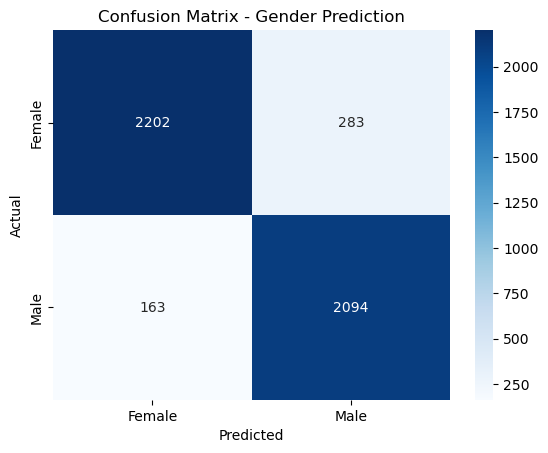


Classification Report:
              precision    recall  f1-score   support

      Female       0.93      0.89      0.91      2485
        Male       0.88      0.93      0.90      2257

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742



In [14]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get all true labels and predictions for gender
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0)
    gender_preds = (predictions[0] > 0.5).astype(int).flatten()
    gender_true = labels['gender_output'].numpy().astype(int).flatten()

    y_true.extend(gender_true)
    y_pred.extend(gender_preds)

# Calculate Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Gender Classification Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gender Prediction")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Female", "Male"]))

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
from collections import deque

# Load the trained model
model = load_model('best_age_gender_model.keras', compile=False)
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': MeanAbsoluteError()
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': MeanAbsoluteError()
    }
)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# For stabilizing predictions
age_history = {}
gender_history = {}
MAX_HISTORY = 10

def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (64, 64))
    face_img = face_img.astype('float32') / 255.0
    return np.expand_dims(face_img, axis=0)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for idx, (x, y, w, h) in enumerate(faces):
        face_img = frame[y:y+h, x:x+w]
        input_img = preprocess_face(face_img)

        gender_pred_prob, age_pred = model.predict(input_img, verbose=0)
        gender_label = "Female" if gender_pred_prob[0][0] > 0.5 else "Male"
        age_value = int(age_pred[0][0])

        # Keep prediction history
        if idx not in age_history:
            age_history[idx] = deque(maxlen=MAX_HISTORY)
            gender_history[idx] = deque(maxlen=MAX_HISTORY)

        age_history[idx].append(age_value)
        gender_history[idx].append(gender_label)

        # Stable prediction
        stable_age = int(np.median(age_history[idx]))
        stable_gender = max(set(gender_history[idx]), key=gender_history[idx].count)

        text = f"{stable_gender}, Age: {stable_age}"
        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(frame, (x, y - th - 10), (x + tw, y), (0, 255, 0), -1)
        cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imshow("Age & Gender Prediction (Stable)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()